In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

# energyflow imports
import energyflow as ef
from energyflow.utils import remap_pids

import inspect

Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22) 
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('legend', fontsize=15)

In [4]:
print(tf.__version__)

1.15.0


# Load Data

## Utilities

In [5]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [6]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    #remap_pids(X, pid_i=3)
    return X

## Process data

In [7]:
# Path to downloaded data from Zenodo
data_dir = '/data0/users/aandreassen/zenodo/'

In [8]:
dataset = np.load(data_dir + '1D_probStoUD_train.npz')

In [9]:
X = dataset['X']
Y = dataset['Y']

In [10]:
X = preprocess_data(X)
Y = to_categorical(Y, num_classes=2)

In [11]:
# strange hadrons particle IDs
strange_PIDs = np.array([130, 310, 311, 321, 3122, 3222, 3212, 3112])

# add anti-particles
strange_PIDs = np.concatenate([strange_PIDs,-strange_PIDs])
X_strangeness = []
#More preprocessing: zipping data points with no particle with parameters

for event in X:
    probStoUD = event[0][6]
    PIDs = event[:, 3]
    number_strange_hadrons = 0
    for PID in PIDs:
        number_strange_hadrons += PID in strange_PIDs
    X_strangeness.append([number_strange_hadrons, probStoUD])

In [12]:
X_strangeness = np.array(X_strangeness)

In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(X_strangeness, Y, test_size=0.2)

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the first Gaussian Notebook.

## Build Model

In [14]:
inputs = Input((2,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics= ['accuracy'])

## Train DCTR model

In [15]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
               epochs=200, batch_size = 10000, 
               validation_data = (X_val, Y_val), 
               verbose = 1, 
               callbacks = [earlystopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1440000 samples, validate on 360000 samples
Epoch 1/200





1440000/1440000 [==============================] - 4s 3us/step - loss: 0.6919 - acc: 0.5161 - val_loss: 0.6912 - val_acc: 0.5229
Epoch 2/200
1440000/1440000 [==============================] - 2s 1us/step - loss: 0.6905 - acc: 0.5247 - val_loss: 0.6903 - val_acc: 0.5237
Epoch 3/200
1440000/1440000 [==============================] - 2s 1us/step - loss: 0.6899 - acc: 0.5272 - val_loss: 0.6900 - val_acc: 0.5262
Epoch 4/200
1440000/1440000 [==============================] - 2s 1us/step - loss: 0.6898 - acc: 0.5275 - val_loss: 0.6899 - val_acc: 0.5256
Epoch 5/200
1440000/1440000 [==============================] - 2s 1us/step - loss: 0.6897 - acc: 0.5279 - val_loss: 0.6899 - val_acc: 0.5261
Epoch 6/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6897 - acc: 0.5276 - val_loss: 0.6898 - val_acc: 0.5268

# Alternative Fit

## Setup the dataset


In [16]:
default_dataset = np.load(data_dir + 'test1D_default.npz')
unknown_dataset = np.load(data_dir + 'test1D_alphaS.npz')

In [17]:
X_0_jet = default_dataset['jet']
X_0 = []
for event in X_0_jet:
    PIDs = event[:, 3]
    number_strange_hadrons = 0
    for PID in PIDs:
        number_strange_hadrons += PID in strange_PIDs
    X_0.append([number_strange_hadrons])
X_0 = np.array(X_0)

X_1_jet = unknown_dataset['jet']
X_1 = []
for event in X_1_jet:
    PIDs = event[:, 3]
    number_strange_hadrons = 0
    for PID in PIDs:
        number_strange_hadrons += PID in strange_PIDs
    X_1.append([number_strange_hadrons])
X_1 = np.array(X_1)

In [18]:
labels0 = np.zeros(len(X_0))
labels1 = np.ones(len(X_1))

xvals = np.concatenate([X_0,X_1])
yvals = np.concatenate([labels0,labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals, yvals, test_size=0.5)

## Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [19]:
def reweight(d): #from NN (DCTR)
    f = dctr_model(d)
    weights = (f[:,1])/(f[:,0])
    weights = K.expand_dims(weights, axis = 1)
    return weights

## Creating Model

In [20]:
myinputs = Input(shape=(1,), dtype = tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
model.summary()

earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)

def my_loss_wrapper(inputs,val=0):
    x  = inputs
    x = K.squeeze(x, axis = 1)
    x = K.gather(x, np.arange(500))

    theta = 0. #starting value
    #theta0 = tf.constant(val, dtype= tf.float32)#target value
    
    #creating tensor with same shape as inputs, with val in every entry
    theta0_stack = K.constant(val, dtype=tf.float32, shape = x.shape)
    #combining and reshaping into correct format:
    data = K.stack((x, theta0_stack), axis=-1) 
    
    w = reweight(data) #NN reweight
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        #t_loss = y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [21]:
thetas = np.linspace(0.10, 0.30, 33)
lvals = []
vlvals = []

for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper(myinputs, theta),
                  metrics=['accuracy'])
    model.fit(np.array(X_train),
              y_train,
              epochs=100,
              batch_size=500,
              validation_data=(np.array(X_test), y_test),
              verbose=1,
              callbacks=[earlystopping])
    lvals += [np.min(model.history.history['loss'])]
    vlvals += [np.min(model.history.history['val_loss'])]
    print
    pass
print(vlvals)

testing theta = : 0.1
Train on 900000 samples, validate on 900000 samples
Epoch 1/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6658 - acc: 0.5195 - val_loss: 0.6649 - val_acc: 0.5180
Epoch 2/100
900000/900000 [==============================] - 7s 7us/step - loss: 0.6654 - acc: 0.5200 - val_loss: 0.6649 - val_acc: 0.5203
Epoch 3/100
900000/900000 [==============================] - 7s 7us/step - loss: 0.6654 - acc: 0.5196 - val_loss: 0.6649 - val_acc: 0.5180
Epoch 4/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6654 - acc: 0.5199 - val_loss: 0.6651 - val_acc: 0.5203
Epoch 5/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6654 - acc: 0.5195 - val_loss: 0.6649 - val_acc: 0.5180
Epoch 6/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6653 - acc: 0.5202 - val_loss: 0.6651 - val_acc: 0.5180
Epoch 7/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6653 - ac

Epoch 15/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6716 - acc: 0.5204 - val_loss: 0.6712 - val_acc: 0.5203
Epoch 16/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6716 - acc: 0.5204 - val_loss: 0.6714 - val_acc: 0.5180
Epoch 17/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6716 - acc: 0.5208 - val_loss: 0.6713 - val_acc: 0.5180
Epoch 18/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6716 - acc: 0.5207 - val_loss: 0.6714 - val_acc: 0.5203
Epoch 19/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6716 - acc: 0.5201 - val_loss: 0.6714 - val_acc: 0.5203
Epoch 20/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6716 - acc: 0.5208 - val_loss: 0.6713 - val_acc: 0.5203
Epoch 21/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6716 - acc: 0.5201 - val_loss: 0.6713 - val_acc: 0.5203
Epoch 22/100
900000/

Epoch 6/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6765 - acc: 0.5211 - val_loss: 0.6762 - val_acc: 0.5203
Epoch 7/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6764 - acc: 0.5210 - val_loss: 0.6763 - val_acc: 0.5203
Epoch 8/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6764 - acc: 0.5212 - val_loss: 0.6762 - val_acc: 0.5203
Epoch 9/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6764 - acc: 0.5211 - val_loss: 0.6763 - val_acc: 0.5203
Epoch 10/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6764 - acc: 0.5211 - val_loss: 0.6762 - val_acc: 0.5203
Epoch 11/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6764 - acc: 0.5209 - val_loss: 0.6762 - val_acc: 0.5203
Epoch 12/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6764 - acc: 0.5210 - val_loss: 0.6762 - val_acc: 0.5203
Epoch 13/100
900000/9000

900000/900000 [==============================] - 7s 8us/step - loss: 0.6796 - acc: 0.5212 - val_loss: 0.6794 - val_acc: 0.5203
Epoch 32/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6796 - acc: 0.5212 - val_loss: 0.6793 - val_acc: 0.5203
Epoch 33/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6796 - acc: 0.5212 - val_loss: 0.6794 - val_acc: 0.5203
Epoch 34/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6796 - acc: 0.5212 - val_loss: 0.6794 - val_acc: 0.5203
Epoch 35/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6796 - acc: 0.5212 - val_loss: 0.6794 - val_acc: 0.5203
Epoch 36/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6796 - acc: 0.5211 - val_loss: 0.6795 - val_acc: 0.5203
Epoch 37/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6796 - acc: 0.5212 - val_loss: 0.6794 - val_acc: 0.5203
Epoch 38/100
900000/900000 [=====

900000/900000 [==============================] - 7s 8us/step - loss: 0.6843 - acc: 0.5213 - val_loss: 0.6842 - val_acc: 0.5203
Epoch 8/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6843 - acc: 0.5212 - val_loss: 0.6842 - val_acc: 0.5203
Epoch 9/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6843 - acc: 0.5211 - val_loss: 0.6843 - val_acc: 0.5203
Epoch 10/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6843 - acc: 0.5212 - val_loss: 0.6842 - val_acc: 0.5203
Epoch 11/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6843 - acc: 0.5212 - val_loss: 0.6842 - val_acc: 0.5203
Epoch 12/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6843 - acc: 0.5211 - val_loss: 0.6842 - val_acc: 0.5203
Epoch 13/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6843 - acc: 0.5212 - val_loss: 0.6842 - val_acc: 0.5203
Epoch 14/100
900000/900000 [=======

900000/900000 [==============================] - 7s 8us/step - loss: 0.6877 - acc: 0.5212 - val_loss: 0.6876 - val_acc: 0.5203
Epoch 16/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6877 - acc: 0.5212 - val_loss: 0.6877 - val_acc: 0.5203
Epoch 17/100
900000/900000 [==============================] - 7s 8us/step - loss: 0.6877 - acc: 0.5212 - val_loss: 0.6877 - val_acc: 0.5203
Epoch 18/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6877 - acc: 0.5212 - val_loss: 0.6877 - val_acc: 0.5203
testing theta = : 0.18125
Train on 900000 samples, validate on 900000 samples
Epoch 1/100
900000/900000 [==============================] - 9s 10us/step - loss: 0.6889 - acc: 0.5211 - val_loss: 0.6888 - val_acc: 0.5203
Epoch 2/100
900000/900000 [==============================] - 8s 8us/step - loss: 0.6889 - acc: 0.5212 - val_loss: 0.6888 - val_acc: 0.5203
Epoch 3/100
900000/900000 [==============================] - 8s 8us/step - loss: 0.6889 - acc: 0

900000/900000 [==============================] - 8s 9us/step - loss: 0.6896 - acc: 0.5210 - val_loss: 0.6896 - val_acc: 0.5203
Epoch 5/100
900000/900000 [==============================] - 8s 8us/step - loss: 0.6896 - acc: 0.5211 - val_loss: 0.6896 - val_acc: 0.5203
Epoch 6/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6896 - acc: 0.5206 - val_loss: 0.6896 - val_acc: 0.5203
Epoch 7/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6896 - acc: 0.5210 - val_loss: 0.6896 - val_acc: 0.5203
Epoch 8/100
900000/900000 [==============================] - 8s 8us/step - loss: 0.6896 - acc: 0.5211 - val_loss: 0.6896 - val_acc: 0.5203
Epoch 9/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6896 - acc: 0.5209 - val_loss: 0.6896 - val_acc: 0.5203
Epoch 10/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6896 - acc: 0.5209 - val_loss: 0.6896 - val_acc: 0.5203
Epoch 11/100
900000/900000 [==========

900000/900000 [==============================] - 8s 9us/step - loss: 0.6892 - acc: 0.5200 - val_loss: 0.6892 - val_acc: 0.5203
Epoch 10/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6892 - acc: 0.5199 - val_loss: 0.6892 - val_acc: 0.5203
Epoch 11/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6892 - acc: 0.5199 - val_loss: 0.6893 - val_acc: 0.5180
Epoch 12/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6892 - acc: 0.5205 - val_loss: 0.6892 - val_acc: 0.5180
Epoch 13/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6892 - acc: 0.5201 - val_loss: 0.6892 - val_acc: 0.5180
Epoch 14/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6892 - acc: 0.5204 - val_loss: 0.6892 - val_acc: 0.5203
Epoch 15/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6892 - acc: 0.5196 - val_loss: 0.6892 - val_acc: 0.5180
Epoch 16/100
900000/900000 [=====

900000/900000 [==============================] - 8s 9us/step - loss: 0.6886 - acc: 0.5192 - val_loss: 0.6887 - val_acc: 0.5180
Epoch 21/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6886 - acc: 0.5186 - val_loss: 0.6887 - val_acc: 0.5203
Epoch 22/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6886 - acc: 0.5187 - val_loss: 0.6887 - val_acc: 0.5180
Epoch 23/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6886 - acc: 0.5187 - val_loss: 0.6887 - val_acc: 0.5203
Epoch 24/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6886 - acc: 0.5189 - val_loss: 0.6887 - val_acc: 0.5180
Epoch 25/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6886 - acc: 0.5190 - val_loss: 0.6887 - val_acc: 0.5180
Epoch 26/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6886 - acc: 0.5194 - val_loss: 0.6887 - val_acc: 0.5180
testing theta = : 0.2375
Train on

900000/900000 [==============================] - 8s 9us/step - loss: 0.6884 - acc: 0.5188 - val_loss: 0.6885 - val_acc: 0.5180
Epoch 16/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6884 - acc: 0.5186 - val_loss: 0.6885 - val_acc: 0.5180
Epoch 17/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6884 - acc: 0.5185 - val_loss: 0.6885 - val_acc: 0.5180
Epoch 18/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6884 - acc: 0.5186 - val_loss: 0.6885 - val_acc: 0.5180
Epoch 19/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6884 - acc: 0.5187 - val_loss: 0.6885 - val_acc: 0.5180
Epoch 20/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6884 - acc: 0.5187 - val_loss: 0.6885 - val_acc: 0.5180
Epoch 21/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6884 - acc: 0.5185 - val_loss: 0.6885 - val_acc: 0.5180
Epoch 22/100
900000/900000 [=====

testing theta = : 0.275
Train on 900000 samples, validate on 900000 samples
Epoch 1/100
900000/900000 [==============================] - 11s 12us/step - loss: 0.6883 - acc: 0.5001 - val_loss: 0.6885 - val_acc: 0.5001
Epoch 2/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6883 - acc: 0.4999 - val_loss: 0.6885 - val_acc: 0.5001
Epoch 3/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6883 - acc: 0.5020 - val_loss: 0.6885 - val_acc: 0.5001
Epoch 4/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6883 - acc: 0.5008 - val_loss: 0.6885 - val_acc: 0.5001
Epoch 5/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6883 - acc: 0.5003 - val_loss: 0.6885 - val_acc: 0.5001
Epoch 6/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6883 - acc: 0.5000 - val_loss: 0.6885 - val_acc: 0.5001
Epoch 7/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6883 

900000/900000 [==============================] - 8s 9us/step - loss: 0.6889 - acc: 0.4819 - val_loss: 0.6892 - val_acc: 0.4798
Epoch 16/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6889 - acc: 0.4812 - val_loss: 0.6892 - val_acc: 0.4798
Epoch 17/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6889 - acc: 0.4814 - val_loss: 0.6892 - val_acc: 0.4798
Epoch 18/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6889 - acc: 0.4810 - val_loss: 0.6892 - val_acc: 0.4799
Epoch 19/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6889 - acc: 0.4815 - val_loss: 0.6892 - val_acc: 0.4799
Epoch 20/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6889 - acc: 0.4820 - val_loss: 0.6892 - val_acc: 0.4798
Epoch 21/100
900000/900000 [==============================] - 8s 9us/step - loss: 0.6889 - acc: 0.4813 - val_loss: 0.6892 - val_acc: 0.4798
Epoch 22/100
900000/900000 [=====

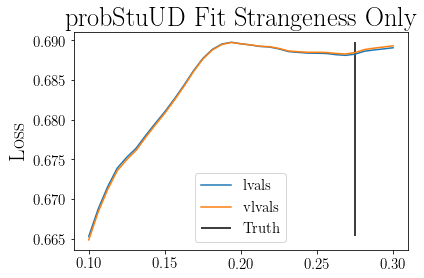

In [29]:
plt.plot(thetas, lvals, label = 'lvals')
plt.plot(thetas, vlvals, label = 'vlvals')
#lt.xlabel('$\theta$')
plt.ylabel('Loss')
plt.title("probStuUD Fit Strangeness Only")
plt.vlines(0.275, ymin = np.min(lvals), ymax = np.max(vlvals), label = 'Truth')
plt.legend(loc='lower center')
#plt.savefig("probStuUD_Fit_StrangenessOnly.png")
plt.show()

## Validating Reweighting

In [30]:
# Define labels for legends
label_0 = r'probStoUD=0.217'

label_1 = r'probStoUD=0.275'

pythia_text = r'\textsc{Pythia 8}' + '\n' + r'$e^+e^- \to Z \to $ dijets' +'\n'+ r"anti-$k_{\mathrm{T}}$, $R=0.8$"
def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg.set_title(pythia_text, prop={'size':14})
    leg._legend_box.align = "left"
    plt.tight_layout()

In [31]:
X_0_inputs = np.concatenate([X_0, 0.275*np.ones_like(X_0)], axis = 1)

f = dctr_model.predict(X_0_inputs)
weights_1 = f[:,1]/f[:,0]

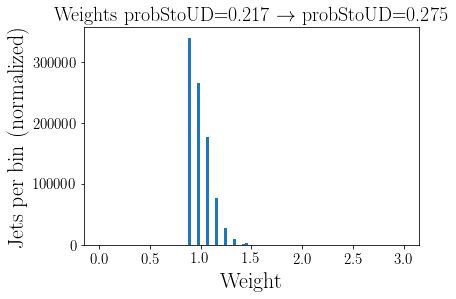

In [32]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r' $\rightarrow$ ' + label_1, fontsize=20)
plt.show()

In [33]:
# Define default plot styles
plot_style_0 = {'histtype':'step', 'color':'black', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'alpha':0.5, 'density':True}

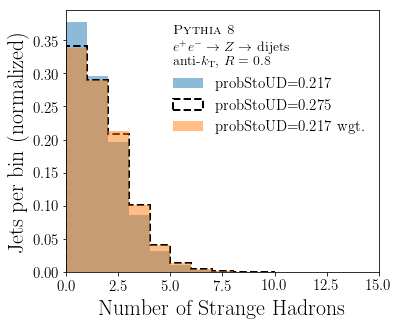

In [34]:
plt.figure(figsize=(6,5))
bins = np.linspace(0,10,11)
hist0 = plt.hist(X_0, bins = bins, label = label_0, **plot_style_1)
hist1 = plt.hist(X_1, bins = bins, label = label_1, **plot_style_0)
hist2 = plt.hist(X_0, bins = bins, label = label_0 + ' wgt.' , weights=weights_1, **plot_style_1)

plt.xlabel('Number of Strange Hadrons')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([0,15])
make_legend()
#plt.savefig("probStuUD_Fit_StrangenessOnly_Hist.png")
plt.show()

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

In [ ]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = 0.12
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

In [ ]:
myinputs_fit = Input(shape=(1,))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=list(),initializer = keras.initializers.Constant(value = theta_fit_init),trainable=True)
model_fit.summary()

train_theta = False

batch_size = int(len(X_0)/50) #larger batch_size leads to better precision
epochs = 20 #but requires more epochs to train

def my_loss_wrapper_fit(inputs,mysign = 1):
    x  = inputs
    x = K.squeeze(x, axis = 1)
    x = K.gather(x, np.arange(batch_size))
    theta = 0. #starting value
    #Getting theta0:
    if train_theta == False:
        theta0 = model_fit.layers[-1].get_weights() #when not training theta, fetch as np array 
    else:
        theta0 = model_fit.trainable_weights[-1] #when trainingn theta, fetch as tf.Variable
        
    #creating tensor with same shape as inputs, with val in every entry 
    theta0_stack = K.ones_like(x,dtype=tf.float32)*theta0 
    
    #combining and reshaping into correct format:
    data = K.stack((x, theta0_stack), axis=-1) 
   
    w = reweight(data) #NN reweight
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        t_loss = mysign*(y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2)
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        '''
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -mysign*((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss
    
for k in range(epochs):    
    print("Epoch: ",k )
    for i in range(len(model_fit.layers)-1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass
    
    train_theta = False
    model_fit.layers[-1].trainable = False
    #model.summary()    
    
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit,1),metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train), y_train, epochs=1, batch_size=batch_size,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=callbacks)

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit,-1),metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train), y_train, epochs=1, batch_size=batch_size,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=callbacks)    
    pass
    

In [ ]:
plt.plot(fit_vals, label='Model Fit')
plt.hlines(0.16, 0, len(fit_vals), label = 'Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("N = {:.0e}, batch_size = {:.0f}, Epochs = {:.0f}".format(len(X_0), batch_size, epochs*2))
#plt.savefig(":N = {:.0e}, batch_size = {:.0f}, Epochs = {:.0f}".format(N, batch_size, epochs))
plt.show()